In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [3]:
RANDOM_STATE=111

### Getting the dataset

The dataset is packed in a zipped folder on UC Irvine's page, thus we need to download and extract the zip folder before we start working with it.
Besides the daily and hourly bike sharing datasets, the folder contains a README file too - here we'll use just the hourly one called `hour.csv`

In [362]:
import requests
import os
import shutil

In [369]:
URL= "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
FILENAME = URL.split("/")[-1]
LOCAL_FOLDER="./data"

LOCAL_FILEPATH_ZIP=os.path.join(LOCAL_FOLDER,FILENAME)
LOCAL_FILEPATH_HOURLY_CSV= os.path.join(LOCAL_FOLDER,"hour.csv")

resp = requests.get(URL)
resp.raise_for_status()

In [370]:
os.makedirs(LOCAL_FOLDER, exist_ok=True)
with open(LOCAL_FILEPATH_ZIP, "wb") as zipin:
    zipin.write(resp.content)

In [371]:
! ls -lh  data

total 2952
-rw-r--r--  1 abarabas  staff   273K Oct 30 20:41 Bike-Sharing-Dataset.zip
-rw-r--r--  1 abarabas  staff   5.5K Oct 30 20:39 Readme.txt
-rw-r--r--  1 abarabas  staff    56K Oct 30 20:39 day.csv
-rw-r--r--  1 abarabas  staff   1.1M Oct 30 20:39 hour.csv


In [372]:
shutil.unpack_archive(LOCAL_FILEPATH_ZIP, extract_dir=LOCAL_FOLDER)

In [373]:
! ls -lh  data

total 4912
-rw-r--r--  1 abarabas  staff   273K Oct 30 20:41 Bike-Sharing-Dataset.zip
-rw-r--r--  1 abarabas  staff   5.5K Oct 30 20:41 Readme.txt
-rw-r--r--  1 abarabas  staff    56K Oct 30 20:41 day.csv
-rw-r--r--  1 abarabas  staff   1.1M Oct 30 20:41 hour.csv


In [374]:
df = pd.read_csv(LOCAL_FILEPATH_HOURLY_CSV, header=0)

In [445]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## EDA
In this section, I'll explore the followings:
- missing values
- ranges of values
- analysis of the target variable
- feature importance analysis

Initial considerations:
 - column `instant` is an index, we're not gonna use it to build the model
 - all the features are numeric, and normalized where needed (temperature, felt temperature, humidity)
 - rental counts by registered and normal users are available but we'll use just the overall as target variable  (`cnt`=`registered` + `casual`)
 - date (`dteday`) and year (`yr`) won't be used to build the model
 


In [376]:
selected_cols = [ 'season', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
# let's see the potentially missing values!
df[selected_cols].isnull().sum()

season        0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

- we don't have missing values for any of the columns, we can go ahead
- let's see value the ranges! at first, we take a look at the features with (supposedly) discrete features, e.g. season from which we have 4 (in Washington DC the climate is continental) or weekday which is either 0 or 1
- besides the value set of each features we can also see how the number of rentals distribute across the values

,season,cnt_rec,sum_rentals
0,1,4242,471348
1,2,4409,918589
2,3,4496,1061129
3,4,4232,841613


,mnth,cnt_rec,sum_rentals
0,1,1429,134933
1,2,1341,151352
2,3,1473,228920
3,4,1437,269094
4,5,1488,331686
5,6,1440,346342
6,7,1488,344948
7,8,1475,351194
8,9,1437,345991
9,10,1451,322352


,hr,cnt_rec,sum_rentals
0,0,726,39130
1,1,724,24164
2,2,715,16352
3,3,697,8174
4,4,697,4428
5,5,717,14261
6,6,725,55132
7,7,727,154171
8,8,727,261001
9,9,727,159438


,holiday,cnt_rec,sum_rentals
0,0,16879,3214244
1,1,500,78435


,weekday,cnt_rec,sum_rentals
0,0,2502,444027
1,1,2479,455503
2,2,2453,469109
3,3,2475,473048
4,4,2471,485395
5,5,2487,487790
6,6,2512,477807


,workingday,cnt_rec,sum_rentals
0,0,5514,1000269
1,1,11865,2292410


,weathersit,cnt_rec,sum_rentals
0,1,11413,2338173
1,2,4544,795952
2,3,1419,158331
3,4,3,223


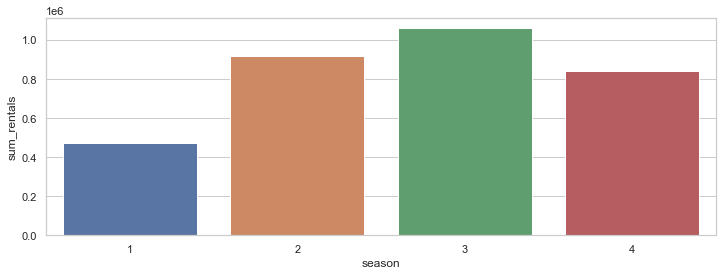

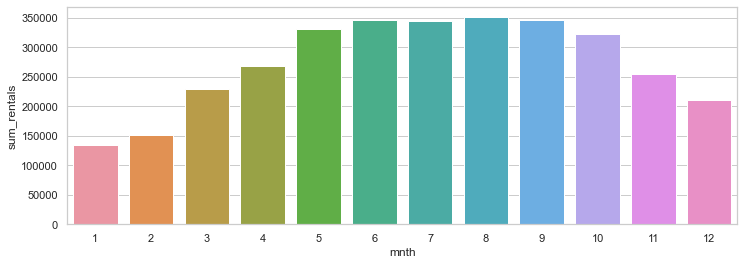

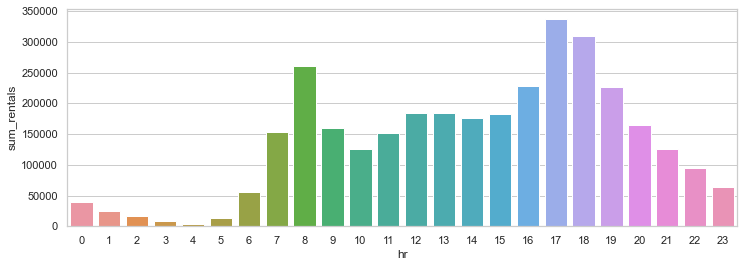

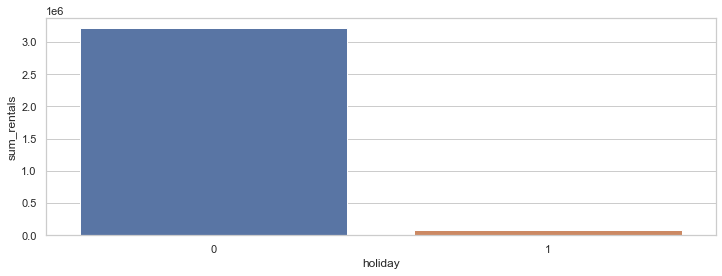

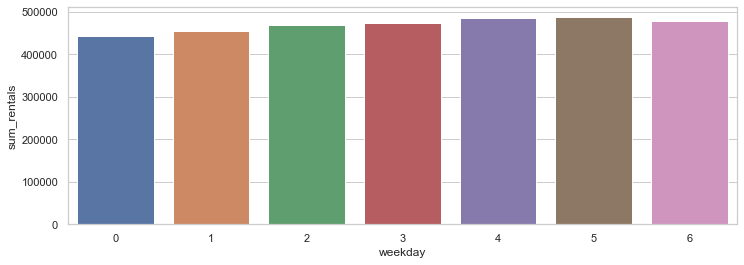

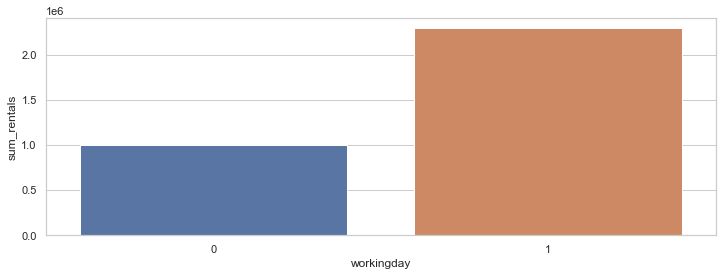

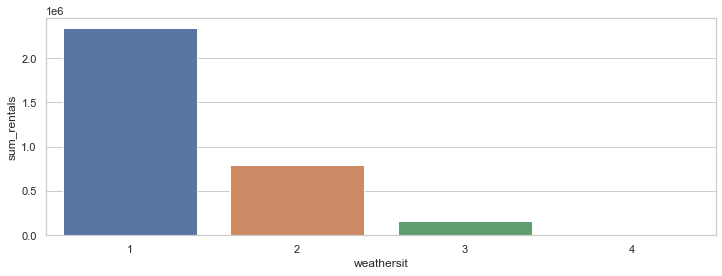

In [127]:
discrete_features = [ "season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]

def plot_feature_w_cnt(feature, size=(12,4)):
        plt.figure(figsize=size)
        plt_df = df[[feature,"cnt"]] \
                .groupby(feature) \
                .agg(cnt_rec=(feature,"count"), sum_rentals=("cnt","sum")) \
                .reset_index()
        display(plt_df)
        sns.barplot(x=plt_df[feature], y=plt_df["sum_rentals"])
        

sns.set_theme(style="whitegrid")
for feature in discrete_features:
    plot_feature_w_cnt(feature)

- we have all the possible values for the considered features (e.g. we have samples for all the four seasons and weather types)
- some things we can observe using the DFs and charts:
    - most of the rentals happen in the fall
    - there are only a few rentals by 4AM , while the busiest times are by 8AM and 5-6PM
    - although there are nominally more rentals on holidays, considering the proportion of workingdays vs holidays, there are more daily rentals on holidays
    - there were only a 3 hours when the weather was "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
    but there were still some rentals
    
#### let's see the continous variables,  including the target variable `cnt`!

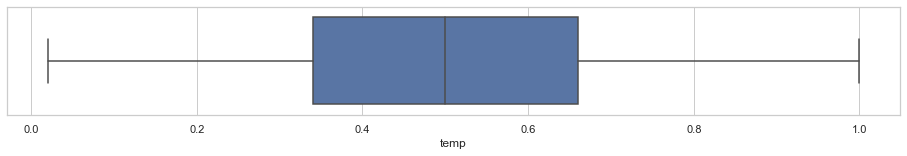

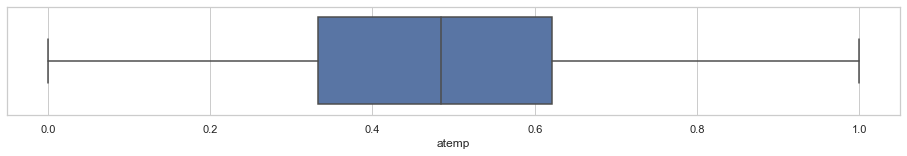

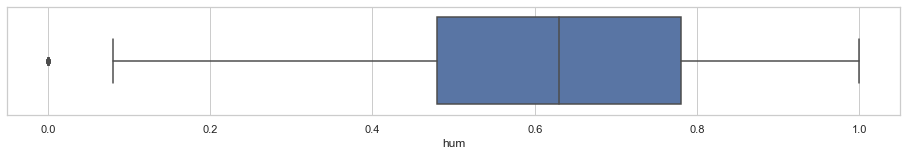

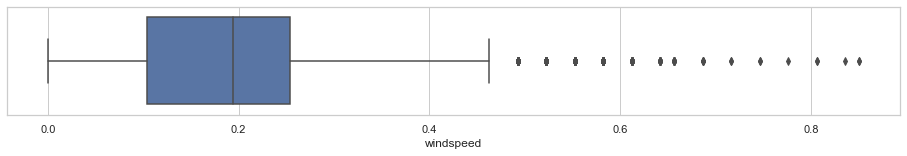

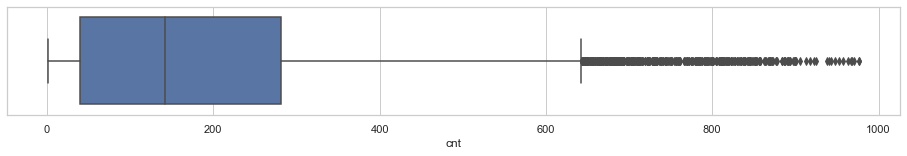

In [131]:
continous_vars = [c for c in selected_cols if c not in discrete_features]
for cf in continous_vars:
    plt.figure(figsize=(16,2))
    sns.boxplot(x=df[cf])

- the values are normalized indeed (between 0 and 1)
- the temperatures and humidity span from 0 to 1, while the highest windspeed is by 0.5, with some outliers
- `cnt` has a high spread and lots of outliers, which can be seen on the below histogram too. thus, I applied a `log1p` transformation on it, after which the distribution of values look way better

<AxesSubplot:xlabel='cnt', ylabel='Count'>

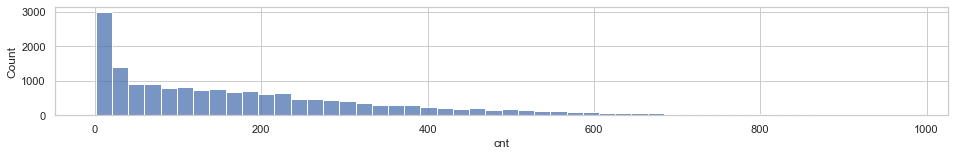

In [135]:
plt.figure(figsize=(16,2))
sns.histplot(df.cnt,bins=50)

In [136]:
df["cnt"] = np.log1p(df.cnt)

<AxesSubplot:xlabel='cnt', ylabel='Count'>

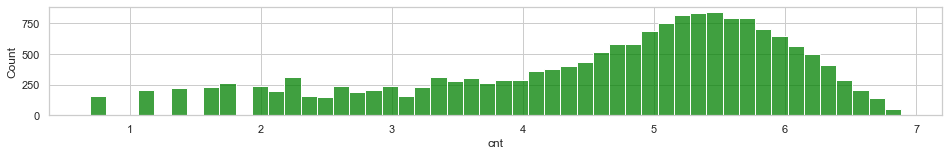

In [138]:
plt.figure(figsize=(16,2))
sns.histplot(df.cnt, bins=50, color="green")

## Building the model

In [229]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_train, df_test = train_test_split(df, test_size=0.3 , random_state=RANDOM_STATE)

## creating train and test datasets

In [290]:
features = [ 'season', 'mnth', 'hr', 'holiday', 'weekday', 
            'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',]

df_train= df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train[features]
y_train = df_train.cnt

X_val = df_test[features]
y_val = df_test.cnt

In [380]:
perf_metrics=list()
overall_best_rmse = 1000000

In [302]:
def calculate_rmse(y_val,y_pred):
    return round(mean_squared_error(y_val,y_pred, squared=False),3)

def plot_predicted_vs_target(y_pred, y_val, model_name=""):
    plt.figure(figsize=(16,4))
    hp=sns.histplot(y_val, label='target', color='blue',  alpha=0.6, bins=100)
    hp=sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=100)
    hp.legend()
    hp.set_title(model_name)

## first try: simple linear regression

In [381]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

rmse_lre = calculate_rmse(y_val,y_pred)
perf_metrics.append({"model_name": str(model),"model": model, "tuning": None, "rmse": rmse_lre})
print(f"linear regression, RMSE: {rmse_lre}")
if rmse_lre < overall_best_rmse:
    overall_best_rmse= rmse_lre

linear regression, RMSE: 1.035


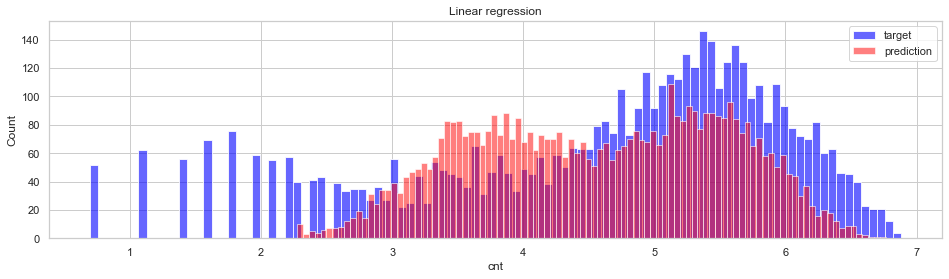

In [382]:
plot_predicted_vs_target(y_pred, y_val,"Linear regression" )

### well, it seems there is room for improvement in case of RMSE=1.035 - let's try Ridge and Lasso regressions with different regularizations!

In [383]:
from sklearn.linear_model import Ridge, Lasso

def run_ridge_experiment(alpha):

    ridge = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    
    ridge.fit(X_train, y_train)

    y_pred_rdg = ridge.predict(X_val)

    return calculate_rmse(y_val,y_pred_rdg), ridge


alphas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 1]
for a in alphas:
    rmse, ridge = run_ridge_experiment(a)
    if rmse < overall_best_rmse:
        overall_best_rmse = rmse
    print(f"Ridge, alpha={a} : RMSE: {rmse}")
    perf_metrics.append({"model_name": str(ridge), "model": ridge, "tuning": {"alpha":a}, "rmse": rmse})
    

Ridge, alpha=0 : RMSE: 1.035
Ridge, alpha=1e-05 : RMSE: 1.035
Ridge, alpha=0.0001 : RMSE: 1.035
Ridge, alpha=0.001 : RMSE: 1.035
Ridge, alpha=0.01 : RMSE: 1.035
Ridge, alpha=0.1 : RMSE: 1.035
Ridge, alpha=0.2 : RMSE: 1.035
Ridge, alpha=0.3 : RMSE: 1.035
Ridge, alpha=0.5 : RMSE: 1.035
Ridge, alpha=0.6 : RMSE: 1.035
Ridge, alpha=1 : RMSE: 1.035


In [400]:
def run_lasso_experiment(alpha):
    lasso = Lasso(alpha=alpha, random_state=RANDOM_STATE)
    lasso.fit(X_train, y_train)

    y_pred_lss = lasso.predict(X_val)

    return calculate_rmse(y_val,y_pred_lss), lasso


# Lasso with alpha==0 is LinearRegression
for a in [a for a in alphas if a >0]:
    res, lasso = run_lasso_experiment(a)
    if res < overall_best_rmse:
        overall_best_rmse = res
    print(f"Lasso, alpha={a} : RMSE: {res}")
    perf_metrics.append({ "model_name": str(lasso),"model": lasso, "tuning": {"alpha":a}, "rmse": res})


Lasso, alpha=1e-05 : RMSE: 1.035
Lasso, alpha=0.0001 : RMSE: 1.035
Lasso, alpha=0.001 : RMSE: 1.035
Lasso, alpha=0.01 : RMSE: 1.039
Lasso, alpha=0.1 : RMSE: 1.149
Lasso, alpha=0.2 : RMSE: 1.159
Lasso, alpha=0.3 : RMSE: 1.161
Lasso, alpha=0.5 : RMSE: 1.167
Lasso, alpha=0.6 : RMSE: 1.171
Lasso, alpha=1 : RMSE: 1.176


### the best RMSE didn't improved significantly but it's still above 1.0.
### let's see if using the `DecisionTreeRegressor` can improve the RMSE! we'll tune the `max_depth` , `min_samples_split` and `min_samples_leaf` parameters step by step.

In [387]:
from sklearn.tree import DecisionTreeRegressor

# using the sklearn defaults for min_samples_split and min_samples_lead
def run_treeregressor_experiment(max_depth, min_samples_split=2, min_samples_leaf=1):

    trgr = DecisionTreeRegressor(max_depth=max_depth,
                                 min_samples_split=min_samples_split, 
                                 min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE)
    trgr.fit(X_train,y_train)
    y_pred_trgr = trgr.predict(X_val)
    return calculate_rmse(y_val, y_pred_trgr), trgr

depths=range(1,15)
min_splits=[2,3,5,10,15,50,100,150,200]
min_leafs=[1, 5, 10, 15, 20, 50, 100, 200]

best_rmse=10000
best_depth=None
for d in depths:
    _rmse, _model = run_treeregressor_experiment(max_depth=d)
    if _rmse < best_rmse:
        best_rmse = _rmse
        best_depth = d
        if _rmse < overall_best_rmse:
            overall_best_rmse= _rmse
    print(f"DecisionTreeRegressor, max_depth={d} : RMSE: {_rmse}")
    perf_metrics.append({"model_name": str(_model), "model": _model, "tuning": {"max_depth":d}, "rmse": _rmse})
    

DecisionTreeRegressor, max_depth=1 : RMSE: 0.93
DecisionTreeRegressor, max_depth=2 : RMSE: 0.86
DecisionTreeRegressor, max_depth=3 : RMSE: 0.767
DecisionTreeRegressor, max_depth=4 : RMSE: 0.705
DecisionTreeRegressor, max_depth=5 : RMSE: 0.627
DecisionTreeRegressor, max_depth=6 : RMSE: 0.587
DecisionTreeRegressor, max_depth=7 : RMSE: 0.523
DecisionTreeRegressor, max_depth=8 : RMSE: 0.485
DecisionTreeRegressor, max_depth=9 : RMSE: 0.472
DecisionTreeRegressor, max_depth=10 : RMSE: 0.464
DecisionTreeRegressor, max_depth=11 : RMSE: 0.473
DecisionTreeRegressor, max_depth=12 : RMSE: 0.483
DecisionTreeRegressor, max_depth=13 : RMSE: 0.493
DecisionTreeRegressor, max_depth=14 : RMSE: 0.5


In [389]:
best_depth, best_rmse, overall_best_rmse

(10, 0.464, 0.464)

### using the `DecisionTreeRegressor` means significant improvement, the RMSE is already below 0.5. let's continue the tuning, using `max_depth=10` (where RMSE was the lowest) !

In [390]:

for s in min_splits:
    _rmse, _mdl = run_treeregressor_experiment(max_depth=10, min_samples_split=s)
    if _rmse < best_rmse:
        best_rmse = _rmse
        best_mss = s
        if _rmse < overall_best_rmse:
            overall_best_rmse= _rmse
    tuning_params={"max_depth":10, "min_samples_split":s}
    print(f"DecisionTreeRegressor, {tuning_params} : RMSE: {_rmse}")
    perf_metrics.append({"model": _mdl, "model_name": str(_mdl),
                         "tuning": tuning_params, 
                         "rmse": _rmse})
best_mss, best_rmse, overall_best_rmse

DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 2} : RMSE: 0.464
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 3} : RMSE: 0.464
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 5} : RMSE: 0.463
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 10} : RMSE: 0.456
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15} : RMSE: 0.454
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 50} : RMSE: 0.459
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 100} : RMSE: 0.474
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 150} : RMSE: 0.493
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 200} : RMSE: 0.51


(15, 0.454, 0.454)

### let's go with `min_samples_split=15` !

In [392]:
best_msl = None

for l in min_leafs:
    _rmse, _mdlml = run_treeregressor_experiment(max_depth=10, min_samples_split=15, min_samples_leaf=l)
    if _rmse < best_rmse:
        best_rmse = _rmse
        best_msl = l
        if _rmse < overall_best_rmse:
            overall_best_rmse= _rmse
    tuning={"max_depth":10, "min_samples_split":15, "min_samples_leaf": l}
    print(f"DecisionTreeRegressor, {tuning} : RMSE: {_rmse}")
    perf_metrics.append({"model": _mdlml, "model_name": str(_mdlml), 
                         "tuning": tuning, 
                         "rmse": _rmse})

DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1} : RMSE: 0.454
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 5} : RMSE: 0.456
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 10} : RMSE: 0.456
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 15} : RMSE: 0.452
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 20} : RMSE: 0.457
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 50} : RMSE: 0.494
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 100} : RMSE: 0.538
DecisionTreeRegressor, {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 200} : RMSE: 0.618


In [393]:
best_msl, best_rmse, overall_best_rmse

(15, 0.452, 0.452)

### so our "winner" model for DecisionTreeRegressor is: `DecisionTreeRegressor(max_depth=10, min_samples_split=15, min_samples_leaf=15)` . let's visualize the distribution the predicted vs real values!


In [349]:
best_decisiontree_regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=15, min_samples_leaf=15)

In [317]:
best_decisiontree_regressor.fit(X_train,y_train)
y_pred_best_trgr = best_decisiontree_regressor.predict(X_val)

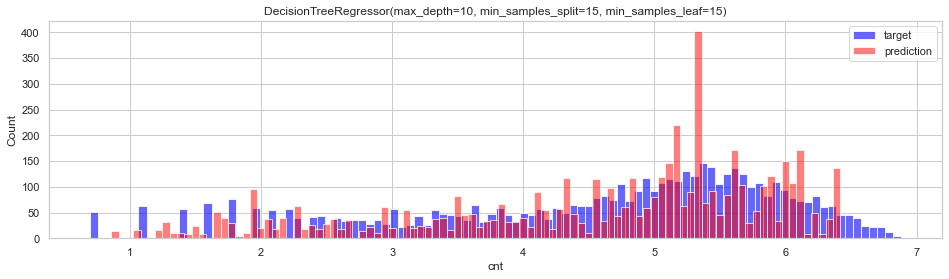

In [318]:
plot_predicted_vs_target(y_pred_best_trgr, y_val,
                         "DecisionTreeRegressor(max_depth=10, min_samples_split=15, min_samples_leaf=15)" )

- apparently we have some outliers (prediction is way higher than the target) among the predictions of `DecisionTreeRegressor`

## let's see the RandomForestRegressor! 

I'll tune the same parameters as did for the DecisionTreeRegressor, namely `max_depth`, `min_samples_split` and
`min_samples_leaf`

In [158]:
from sklearn.ensemble import RandomForestRegressor

In [394]:
def run_rfr_experiment(max_depth, min_samples_split=2, min_samples_leaf=1):
    
    rfr = RandomForestRegressor(max_depth=max_depth, 
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               n_jobs=-1,
                               random_state=RANDOM_STATE)
    rfr.fit(X_train,y_train)
    y_pred_rfr = rfr.predict(X_val)
    return calculate_rmse(y_val, y_pred_rfr) , rfr

depths=range(1,25)
min_splits=[2,3,5,10,15,50,100,150,200]
min_leafs=[1, 5, 10, 15, 20, 50, 100, 200]

best_rmse_rfr=10000
best_depth_rfr=None
for d in depths:
    _rmse, _rfr = run_rfr_experiment(max_depth=d)
    if _rmse < best_rmse_rfr:
        best_rmse_rfr = _rmse
        best_depth_rfr = d
        if _rmse < overall_best_rmse:
            overall_best_rmse = _rmse
    print(f"RandomForestRegressor, max_depth={d} : RMSE: {_rmse}")
    perf_metrics.append({"model_name": str(_rfr), "model": _rfr, "tuning": {"max_depth":d}, "rmse": _rmse})

print(f"\n\t best max_depth value: {best_depth_rfr} with RMSE of {best_rmse_rfr}") 

RandomForestRegressor, max_depth=1 : RMSE: 0.91
RandomForestRegressor, max_depth=2 : RMSE: 0.838
RandomForestRegressor, max_depth=3 : RMSE: 0.742
RandomForestRegressor, max_depth=4 : RMSE: 0.665
RandomForestRegressor, max_depth=5 : RMSE: 0.592
RandomForestRegressor, max_depth=6 : RMSE: 0.546
RandomForestRegressor, max_depth=7 : RMSE: 0.487
RandomForestRegressor, max_depth=8 : RMSE: 0.45
RandomForestRegressor, max_depth=9 : RMSE: 0.427
RandomForestRegressor, max_depth=10 : RMSE: 0.412
RandomForestRegressor, max_depth=11 : RMSE: 0.402
RandomForestRegressor, max_depth=12 : RMSE: 0.396
RandomForestRegressor, max_depth=13 : RMSE: 0.393
RandomForestRegressor, max_depth=14 : RMSE: 0.39
RandomForestRegressor, max_depth=15 : RMSE: 0.389
RandomForestRegressor, max_depth=16 : RMSE: 0.388
RandomForestRegressor, max_depth=17 : RMSE: 0.387
RandomForestRegressor, max_depth=18 : RMSE: 0.386
RandomForestRegressor, max_depth=19 : RMSE: 0.385
RandomForestRegressor, max_depth=20 : RMSE: 0.385
RandomForest

In [395]:
overall_best_rmse

0.385

#### max_depth of 19 seems to be winning but let's check the performance with some of the values in the 16-23 range!

In [396]:
best_rmse_rfr2=10000
best_msl_rfr=-1
best_depth_rfr2=111111

for ml in min_leafs:
    for depth in [16,18,19,22]:
        _rmse, _rf = run_rfr_experiment(max_depth=depth, min_samples_leaf=ml)
        if _rmse < best_rmse_rfr2:
            best_rmse_rfr2 = _rmse
            best_depth_rfr2 = depth
            best_msl_rfr=ml
            if _rmse < overall_best_rmse:
                overall_best_rmse = _rmse
        tuning = {"max_depth":depth, "min_samples_leaf":ml}
        print(f"RandomForestRegressor, {tuning} , RMSE: {_rmse}")
        perf_metrics.append({"model_name": str(_rf), "model": _rf, "tuning": tuning , "rmse": _rmse})
print(f"\n\t best result: max_depth={best_depth_rfr2}, min_samples_leaf={best_msl_rfr} ,RMSE= {best_rmse_rfr2}") 

RandomForestRegressor, {'max_depth': 16, 'min_samples_leaf': 1} , RMSE: 0.388
RandomForestRegressor, {'max_depth': 18, 'min_samples_leaf': 1} , RMSE: 0.386
RandomForestRegressor, {'max_depth': 19, 'min_samples_leaf': 1} , RMSE: 0.385
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1} , RMSE: 0.385
RandomForestRegressor, {'max_depth': 16, 'min_samples_leaf': 5} , RMSE: 0.396
RandomForestRegressor, {'max_depth': 18, 'min_samples_leaf': 5} , RMSE: 0.395
RandomForestRegressor, {'max_depth': 19, 'min_samples_leaf': 5} , RMSE: 0.395
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 5} , RMSE: 0.395
RandomForestRegressor, {'max_depth': 16, 'min_samples_leaf': 10} , RMSE: 0.407
RandomForestRegressor, {'max_depth': 18, 'min_samples_leaf': 10} , RMSE: 0.407
RandomForestRegressor, {'max_depth': 19, 'min_samples_leaf': 10} , RMSE: 0.407
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 10} , RMSE: 0.407
RandomForestRegressor, {'max_depth': 16, 'min_samples_leaf':

### it seems min_samples_leaf is the best at its default (1). now let's see our last parameter-to-tune: `min_samples_split` !

In [397]:
best_rmse_rfr_mss=10000
best_mss= -1
best_depth_mss=111111

for ms in min_splits:
    _rmse, _rrr = run_rfr_experiment(max_depth=22, min_samples_split=ms, min_samples_leaf=1)
    if _rmse < best_rmse_rfr_mss:
        best_rmse_rfr_mss=_rmse
        best_mss = ms
        if _rmse < overall_best_rmse:
            overall_best_rmse = _rmse
    tuning = {"max_depth":22, "min_samples_leaf":1, "min_samples_split":ms}
    print(f"RandomForestRegressor, {tuning} , RMSE: {_rmse}")
    perf_metrics.append({"model": _rrr,"model_name":str(_rrr), "tuning": tuning , "rmse": _rmse})
print(f"\n\t best result: min_samples_split={best_mss} ,RMSE= {best_rmse_rfr_mss}") 

RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2} , RMSE: 0.385
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 3} , RMSE: 0.385
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 5} , RMSE: 0.386
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 10} , RMSE: 0.388
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 15} , RMSE: 0.391
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 50} , RMSE: 0.417
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 100} , RMSE: 0.452
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 150} , RMSE: 0.479
RandomForestRegressor, {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 200} , RMSE: 0.504

	 best result: min_samples_split=2 ,RMSE= 0.385


### apparently, the random forest regressor results the lowest RMSE, and it can be achieved using several different tuning values. let's see the global ranking of all the models we have trained, in order to validate that it's the best model we have!

In [404]:
pd.options.display.max_colwidth = 150
df_perf= pd.DataFrame.from_dict(perf_metrics)
df_perf = df_perf[df_perf.rmse == overall_best_rmse]
df_perf[["model_name","tuning","rmse"]].sort_values(by="rmse", ascending=True)

,model_name,tuning,rmse
85,"RandomForestRegressor(max_depth=19, n_jobs=-1, random_state=111)",{'max_depth': 19},0.385
86,"RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=111)",{'max_depth': 20},0.385
87,"RandomForestRegressor(max_depth=21, n_jobs=-1, random_state=111)",{'max_depth': 21},0.385
88,"RandomForestRegressor(max_depth=22, n_jobs=-1, random_state=111)",{'max_depth': 22},0.385
89,"RandomForestRegressor(max_depth=23, n_jobs=-1, random_state=111)",{'max_depth': 23},0.385
90,"RandomForestRegressor(max_depth=24, n_jobs=-1, random_state=111)",{'max_depth': 24},0.385
93,"RandomForestRegressor(max_depth=19, n_jobs=-1, random_state=111)","{'max_depth': 19, 'min_samples_leaf': 1}",0.385
94,"RandomForestRegressor(max_depth=22, n_jobs=-1, random_state=111)","{'max_depth': 22, 'min_samples_leaf': 1}",0.385
123,"RandomForestRegressor(max_depth=22, n_jobs=-1, random_state=111)","{'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.385
124,"RandomForestRegressor(max_depth=22, min_samples_split=3, n_jobs=-1,\n random_state=111)","{'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 3}",0.385


##  let's pick one of the less restrictive models, e.g. our winning model is RandomForestRegressor(max_depth=19)
- let's visualize the target vs predicted values!

In [405]:
best_randomforest_regressor = RandomForestRegressor(max_depth=19)
best_randomforest_regressor.fit(X_train,y_train)
y_pred_best_rfrgr = best_randomforest_regressor.predict(X_val)

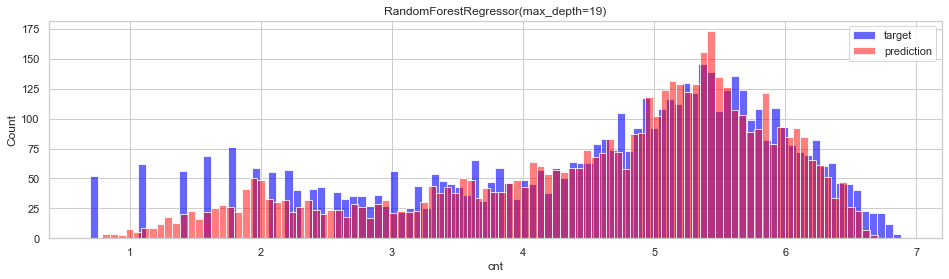

In [406]:
plot_predicted_vs_target(y_pred_best_rfrgr, y_val, 
                         "RandomForestRegressor(max_depth=19)")

- while we don't have so many outliers (errors with high difference) than in the case of DecisionTreeRegressor, the predictions are usually more accurate, but in the lower region of rentals the errors are more frequent

In [443]:
# finally, we export the winner model
import pickle
with open("milestone_model.pickle","wb") as pf:
    pickle.dump(best_randomforest_regressor, pf)